In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/edu-data")
!ls

final_keywords.txt  stem_video_titles_tags_50.xlsx     video_with_country_and_stem.csv
keyword_counts.txt  video_with_channelcountry.csv
__MACOSX	    video_with_channelcountry.csv.zip


In [3]:
# Install required packages
! pip3 install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import csv
import re
import matplotlib.pyplot as plt
from rapidfuzz import fuzz, process
from tqdm import tqdm

This time we set a higher fuzzy matching threshold (90%) and no tag match ratio (i.e only need 1 tag matched to keyword list).

In [5]:
def extract_keywords(filepath):
    """
    Extracts unique keywords from a file with the format "x_keywords: [...]".
    """
    keywords = {}
    with open(filepath, 'r') as file:
        for line in file:
            match = re.match(r"(\w+_keywords)\s*=\s*\[(.*?)\]", line, re.DOTALL)
            if match:
                category = match.group(1)
                keyword_str = match.group(2)
                # Handle both single and double quotes, special characters,
                # remove extra whitespace, and filter out empty strings
                # The change is in the regex:
                keyword_list = [''.join(k).strip().strip("'").strip('"').strip("’") for k in re.findall(r"'([^']*)'|[\"]([^\"]*)[\"]|’([^’]*)’", keyword_str)]
                keyword_list = [keyword for keyword in keyword_list if keyword]
                keywords[category] = keyword_list

    # Flatten the dictionary and remove duplicates
    all_keywords = []
    for category, wordlist in keywords.items():
        all_keywords.extend(wordlist)

    return list(set(all_keywords))

stem_keywords = extract_keywords('/content/drive/MyDrive/edu-data/final_keywords.txt')
len(stem_keywords)

2008

In [6]:
# Extract video data with country field (removing those without any country information)
df_video_with_country = pd.read_csv('/content/drive/MyDrive/edu-data/video_with_channelcountry.csv')
df_video_with_country = df_video_with_country[df_video_with_country['country'].notnull()]

<ipython-input-6-896327dcbe5a>:2: DtypeWarning: Columns (7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_video_with_country = pd.read_csv('/content/drive/MyDrive/edu-data/video_with_channelcountry.csv')


In [9]:
# Pre-process keywords (convert to lowercase)
stem_keywords_lower = [keyword.lower() for keyword in stem_keywords]

def is_stem_video(tags):
    """Checks if a video is STEM based on its tags."""
    if pd.isna(tags):
        return False

    video_tags = tags.lower().split(',')  # Convert tags to lowercase for efficient matching
    matched_tags = 0
    for video_tag in video_tags:
        # Using rapidfuzz's process.extractOne for faster fuzzy matching
        match = process.extractOne(video_tag.strip(), stem_keywords_lower, scorer=fuzz.ratio, score_cutoff=90)
        if match:
            matched_tags += 1

    return matched_tags > 0 # As long as at least 1 tag matched

# Initialize keyword counts with lowercase keys
keyword_counts = {keyword.lower(): 0 for keyword in stem_keywords}

# Apply the is_stem_video function using Pandas apply for vectorization
# with tqdm progress bar
tqdm.pandas(desc="Processing is_stem")
df_video_with_country['is_stem'] = df_video_with_country['tags'].progress_apply(is_stem_video)

# Update keyword counts (this part is still iterative, but it's unavoidable)
for index, row in tqdm(df_video_with_country[df_video_with_country['is_stem']].iterrows(), total=len(df_video_with_country[df_video_with_country['is_stem']])):
    video_tags = row['tags'].lower().split(',')
    for video_tag in video_tags:
        match = process.extractOne(video_tag.strip(), stem_keywords_lower, scorer=fuzz.ratio, score_cutoff=70)
        if match:
            keyword_counts[match[0]] += 1

# Print the number of videos with is_stem = True
stem_video_count = df_video_with_country['is_stem'].sum()
print(f"Number of STEM videos: {stem_video_count}")

100%|██████████| 264843/264843 [24:28<00:00, 180.39it/s]

Number of STEM videos: 264843


In [10]:
# Sample 100 STEM videos
stem_videos = df_video_with_country[df_video_with_country['is_stem'] == True].sample(n=100)

# Print titles and tags
for index, row in stem_videos.iterrows():
  print(f"Title: {row['title']}")
  print(f"Tags: {row['tags']}")
  print("-" * 20)

Title: Ch 4.1 Materials: Metals and Non Metals (Science, Grade 8, CBSE) The LandMark - Hindi Exp Series
Tags: Science,Introduction,force,laws,motion,Easy,Hindi,Explanation,improvement,food,resources,study,study material,hindi study,Subject,notes,explanation,cbse science help,ncert,home study,weak student,study in hindi,hindi,science,science in hindi,hindi main science,science class 8,cbse science,ncert science,help,asa education,performer hub,grade 8,class 8,ASAD-A01
--------------------
Title: Mike NOVOGRATZ NEWEST BITCOIN Opinion Will STUN ALL INVESTORS, But DON’T Be SCARED! BLAST INCOMING!
Tags: bitcoin,bitcoin news,bitcoin price,bitcoin today,bitcoin analysis,bitcoin technical analysis,bitcoin ta,bitcoin news today,bitcoin live,bitcoin 2019,litecoin,bitcoin trading,bitcoin breakout,bitcoin prediction,altcoin,bitcoin price prediction,bitcoin price today,btc,bitcoin price analysis,#bitcoin,bitcoin crash,bakkt bitcoin,bitcoin rally,bitcoin bottom,bitcoin crypto,bitcoin bullish,bitcoin

In [13]:
data = []

# Extract titles and tags and append to the data list
for index, row in stem_videos.iterrows():
  data.append([row['title'], row['tags']])

# Create a Pandas DataFrame
df = pd.DataFrame(data, columns=['Title', 'Tags'])

# Export to Excel
df.to_excel('/content/drive/MyDrive/edu-data/stem_video_titles_tags_0.xlsx', index=False)

Top 10 Countries - Comparison of Total Videos and STEM Videos:
         Total Videos (%)  STEM Videos (%)
country                                   
US              46.734390        50.169346
IN              21.909008        16.573970
GB               7.246793        12.818915
CA               3.409865         3.600624
ES               1.864329         3.386535
AU               1.777452         2.060466
DE               0.908732         1.130481
EG               0.552646         1.110469
CH               0.375073         0.638114
IL               0.740261         0.516155


<Figure size 1200x600 with 0 Axes>

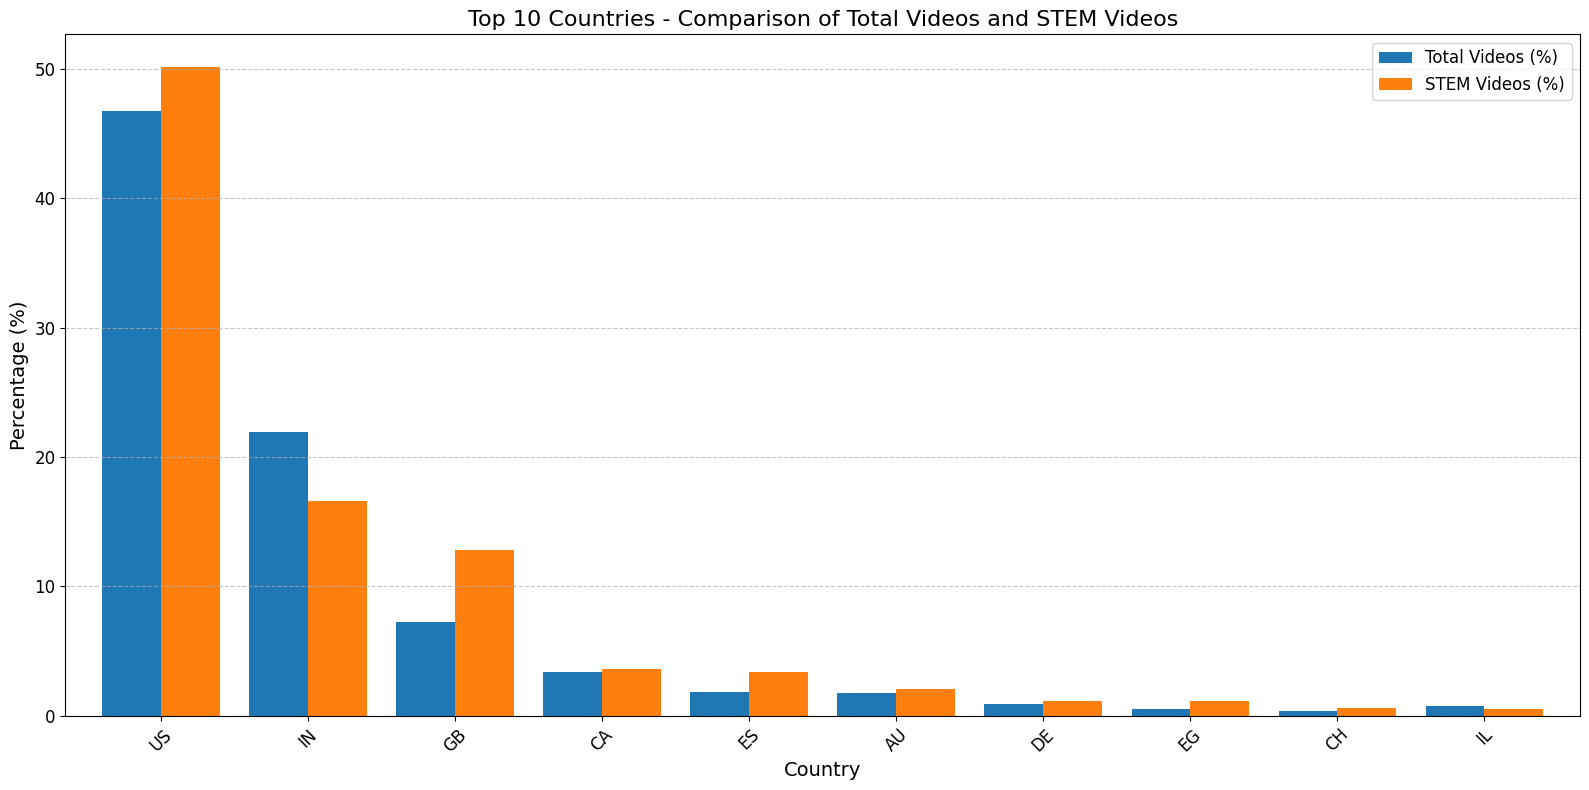

India's Total Video Percentage: 21.91%
India's STEM Video Percentage: 16.57%


In [12]:
total_videos_per_country = df_video_with_country['country'].value_counts(normalize=True) * 100

stem_videos = df_video_with_country[df_video_with_country['is_stem'] == True]
stem_videos_per_country = stem_videos['country'].value_counts(normalize=True) * 100

comparison_df = pd.DataFrame({
    'Total Videos (%)': total_videos_per_country,
    'STEM Videos (%)': stem_videos_per_country
}).fillna(0)

top_10_countries = comparison_df.sort_values('STEM Videos (%)', ascending=False).head(10)

india_total = comparison_df.loc['IN', 'Total Videos (%)'] if 'IN' in comparison_df.index else 0

india_stem = comparison_df.loc['IN', 'STEM Videos (%)'] if 'IN' in comparison_df.index else 0

print("Top 10 Countries - Comparison of Total Videos and STEM Videos:")
print(top_10_countries)

plt.figure(figsize=(12, 6))
top_10_countries[['Total Videos (%)', 'STEM Videos (%)']].plot(kind='bar', figsize=(16, 8), width=0.8)
plt.title('Top 10 Countries - Comparison of Total Videos and STEM Videos', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"India's Total Video Percentage: {india_total:.2f}%")
print(f"India's STEM Video Percentage: {india_stem:.2f}%")

In [14]:
# Extract only the is_stem column because it's so costly saving the whole dataset again
is_stem_column = df_video_with_country['is_stem']

# Save the column to a CSV file
is_stem_column.to_csv('/content/drive/MyDrive/edu-data/is_stem_column_0.csv', index=False)